# IMPORTING LIBRARIES

In [81]:

import numpy as np  
import pandas as pd 
import re
from scipy import stats

# nlp imports
import nltk
import nltk.data
from nltk.corpus import stopwords
import string
from gensim.models.word2vec import Word2Vec

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from collections import Counter



# model imports
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import NuSVC
from sklearn.svm import LinearSVC

# visualisation imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
from multiprocessing.dummy import Pool as ThreadPool 
pool = ThreadPool(4)

In [3]:
df = pd.read_csv('mbti_1.csv')
df['split'] = np.random.randn(df.shape[0], 1)

msk = np.random.rand(len(df)) <= 0.8

train = df[msk]
test = df[~msk]

In [4]:
train.head()

,type,posts,split
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,-0.168309
1,ENTP,'I'm finding the lack of me in these posts ver...,-0.568690
2,INTP,'Good one _____ https://www.youtube.com/wat...,-0.778876
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",-0.720635
4,ENTJ,'You're fired.|||That's another silly misconce...,-1.001265


In [5]:
dist = train['type'].value_counts()

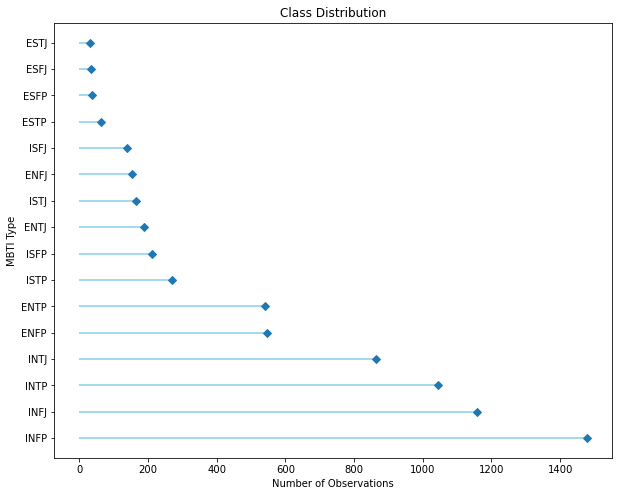

In [6]:
plt.figure(figsize=(10,8),edgecolor='b')
plt.hlines(y=list(range(16)), xmin=0, xmax=dist, color='skyblue')
plt.plot(dist, list(range(16)), "D")
plt.yticks(list(range(16)), dist.index)
plt.xlabel('Number of Observations')
plt.ylabel('MBTI Type')
plt.title('Class Distribution')
plt.show()

In [7]:
def encode_type(df):

    listy = list(df['type'])

    # separate the four letters into the four categories
    mind = [x[0] for x in listy]
    energy = [x[1] for x in listy]
    nature =  [x[2] for x in listy]
    tactics = [x[3] for x in listy]

    # create new columns
    df['mind'] = mind
    df['energy'] = energy
    df['nature'] = nature
    df['tactics'] = tactics

    # assigning integer values to categories
    df['mind'] = df['mind'].apply(lambda x: 1 if x == 'E' else 0)    
    df['energy'] = df['energy'].apply(lambda x: 1 if x == 'N' else 0)
    df['nature'] = df['nature'].apply(lambda x: 1 if x == 'T' else 0)
    df['tactics'] = df['tactics'].apply(lambda x: 1 if x == 'J' else 0)

    return df.drop('type', axis=1)

In [8]:
train = encode_type(train)

<ipython-input-7-6ca1cf30ab19>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mind'] = mind
<ipython-input-7-6ca1cf30ab19>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['energy'] = energy
<ipython-input-7-6ca1cf30ab19>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

In [9]:
train.head()

,posts,split,mind,energy,nature,tactics
0,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,-0.168309,0,1,0,1
1,'I'm finding the lack of me in these posts ver...,-0.568690,1,1,1,0
2,'Good one _____ https://www.youtube.com/wat...,-0.778876,0,1,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",-0.720635,0,1,1,1
4,'You're fired.|||That's another silly misconce...,-1.001265,1,1,1,1


In [10]:
def post_to_wordlist(post, remove_stopwords=False):
    # Function to convert a document to a sequence of words,
    # optionally removing stop words.  Returns a list of words.
    #
    # 1. Remove HTML
    post_text = post
    #
    # 2. Remove non-letters
    post_text = re.sub("[^a-zA-Z]", " ", post_text)
    #
    # 3. Convert words to lower case and split them
    words = post_text.lower().split()
    #
    # 4. Optionally remove stop words (false by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if w not in stops]
    #
    # 5. Return a list of words
    return(words)

In [92]:

# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')


# Define a function to split a review into parsed sentences
def post_to_sentences(post, tokenizer=tokenizer, remove_stopwords=False):
   
    raw_sentences = tokenizer.tokenize(post.strip())

    sentences = []
    for raw_sentence in raw_sentences:
        # If a sentence is empty, skip it
        if len(raw_sentence) > 0:
            # Otherwise, call review_to_wordlist to get a list of words
            sentences.append(post_to_wordlist(raw_sentence, remove_stopwords))

    return sentences

In [12]:
sentences = []  # Initialize an empty list of sentences

print("Parsing sentences from training set")
for post in train['posts']:
    sentences += post_to_sentences(post, tokenizer)

print("Parsing sentences from testing set")
for post in test['posts']:
    sentences += post_to_sentences(post, tokenizer)

Parsing sentences from training set
Parsing sentences from testing set


In [13]:
# Check if sentences exist.
len(sentences)

600061

In [68]:
df_mbti = df

# Feature Selection (ExtraTreeClassifier)

In [75]:

def rem_sw(df):
    # Downloading stop words
    stop_words = set(stopwords.words('english'))
    stop_words |= set(['infj', 'intp', 'infp', 'enfp', 'intj', 'entp', 'istp', 'entj', 'isfp', 'enfj', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj'])

    print(type(df))
    count = 0
    for sentence in df:
        sentence = [word for word in sentence.lower().split() if word not in stop_words]
        sentence = ' '.join(sentence)
        df.loc[count] = sentence
        count+=1
    return(df)

def rem_punc(df):
    count = 0
    for s in df:
        cleanr = re.compile('<.*?>')
        s = re.sub(r'\d+', '', s)
        s = re.sub(cleanr, '', s)
        s = re.sub("'", '', s)
        s = re.sub(r'\W+', ' ', s)
        s = s.replace('_', '')
        df.loc[count] = s
        count+=1
    return(df)

def lemma(df):

    lmtzr = WordNetLemmatizer()

    count = 0
    stemmed = []
    for sentence in df:    
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(lmtzr.lemmatize(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

def stemma(df):

    stemmer = SnowballStemmer("english") #SnowballStemmer("english", ignore_stopwords=True)

    count = 0
    stemmed = []
    for sentence in df:
        word_tokens = word_tokenize(sentence)
        for word in word_tokens:
            stemmed.append(stemmer.stem(word))
        sentence = ' '.join(stemmed)
        df.iloc[count] = sentence
        count+=1
        stemmed = []
    return(df)

def get_feature(df, number):
    
    feature_list = []
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['posts'])

   
    le = LabelEncoder()
    y = le.fit_transform(df['type'])

    # fit the model
    tree_clf.fit(x_train, y)
    
    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    # Create the feature list
    for f in range(number):
        feature_list.append(sorted_features[f][0])
    
    return(feature_list)

def print_feature(df):
    
    # create an instance for tree feature selection
    tree_clf = ExtraTreesClassifier()

    cv = CountVectorizer(analyzer='word')
    x_train = cv.fit_transform(df['posts'])

    # Creating an object for Label Encoder and fitting on target strings
    le = LabelEncoder()
    y = le.fit_transform(df['type'])

    # fit the model
    tree_clf.fit(x_train, y)

    # Preparing variables
    importances = tree_clf.feature_importances_
    feature_names = cv.get_feature_names()
    feature_imp_dict = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    for f in range(20):
        print("feature %d : %s (%f)" % (indices[f], sorted_features[f][0], sorted_features[f][1]))

    # Plot the feature importances of the forest
    plt.figure(figsize = (20,20))
    plt.title("Feature importances")
    plt.bar(range(100), importances[indices[:100]],
           color="r", align="center")
    plt.xticks(range(100), sorted_features[:100], rotation=90)
    plt.xlim([-1, 100])
    plt.show()

    return()

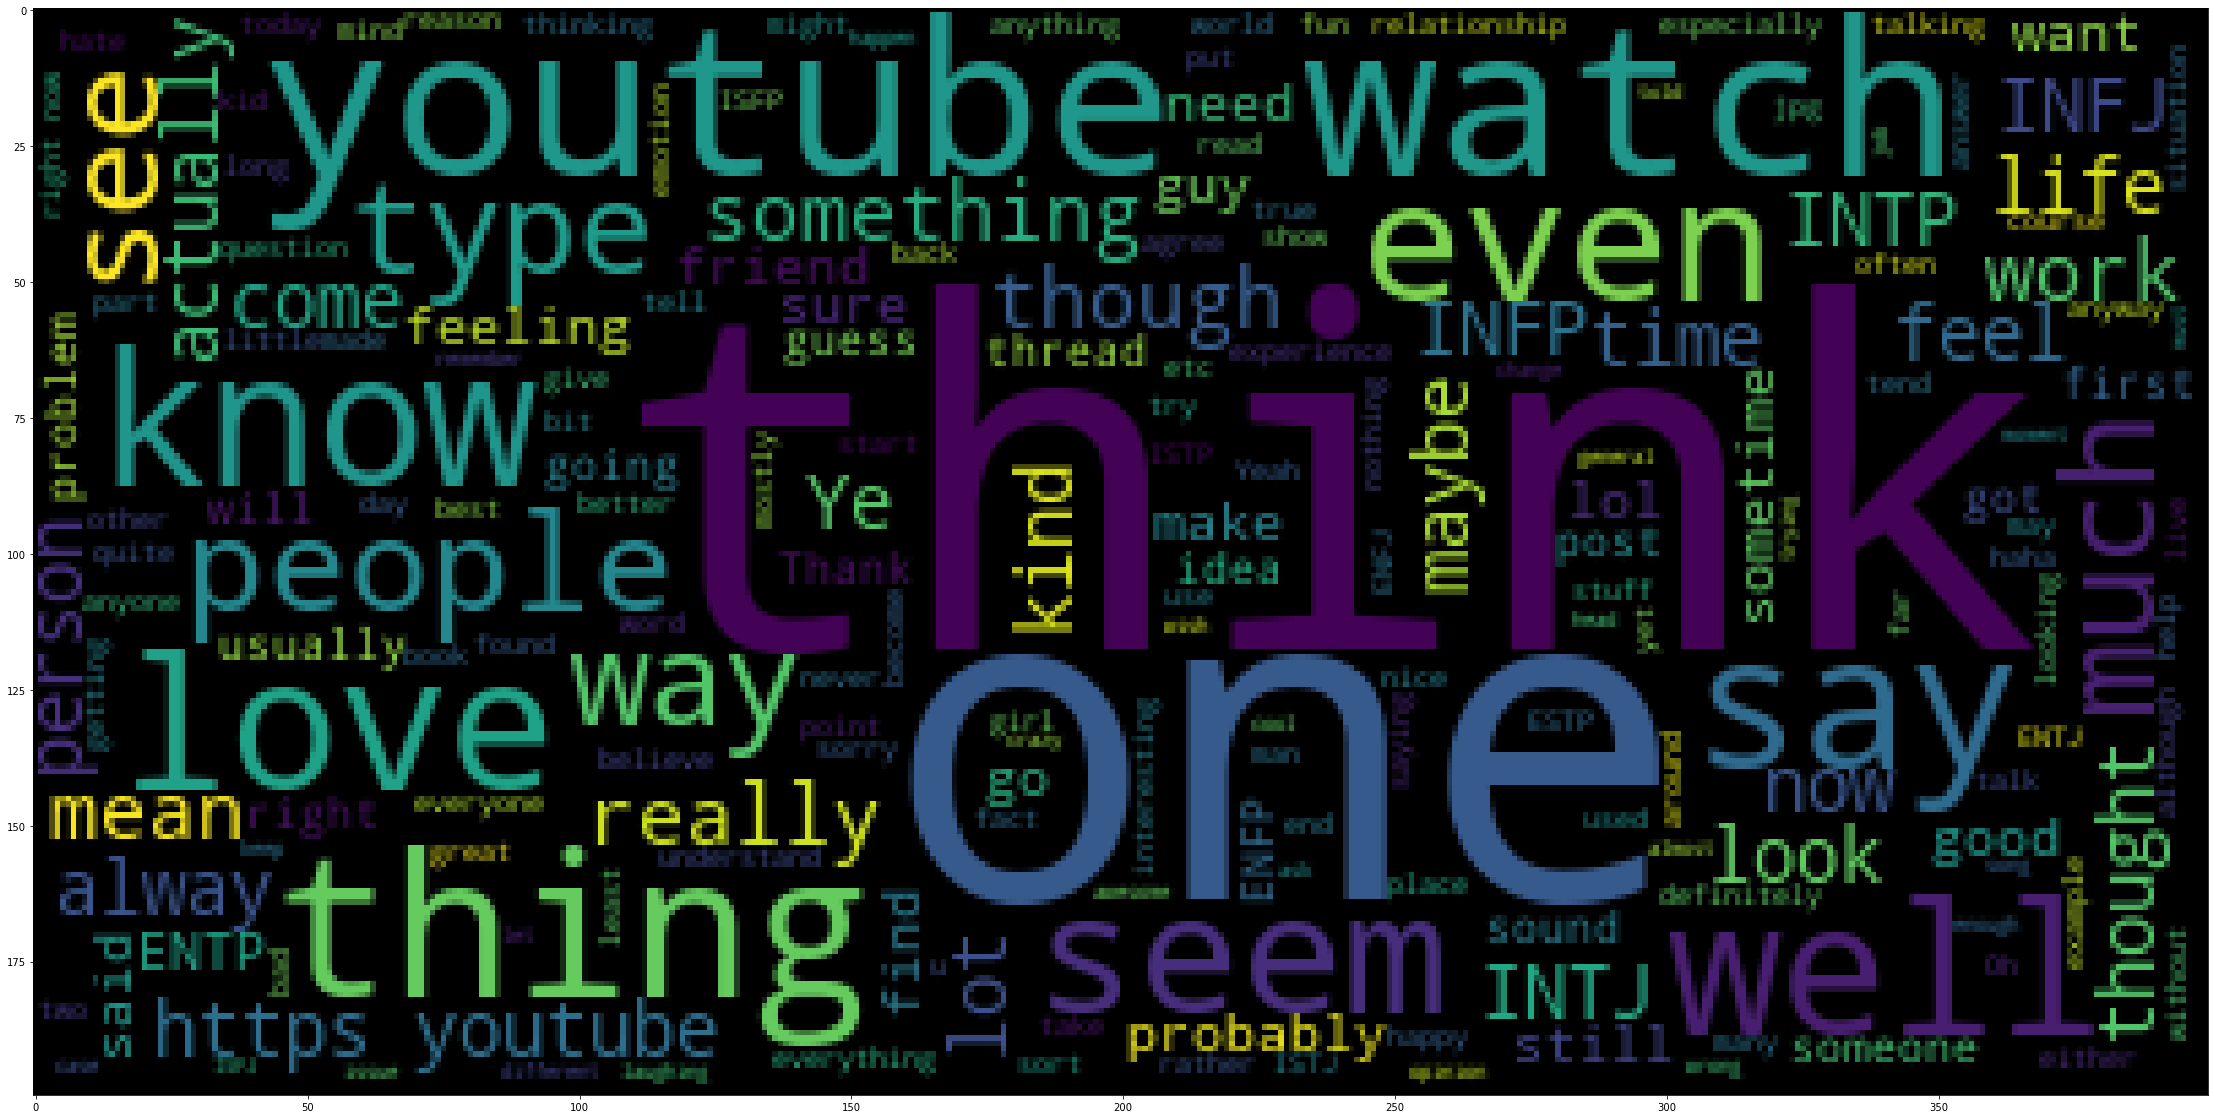

In [69]:

from wordcloud import WordCloud
mbti_list = df_mbti["posts"].unique().tolist()
mbti_bow = " ".join(mbti_list)

# Create a word cloud for psitive words
mbti_wordcloud = WordCloud().generate(mbti_bow)

# Show the created image of word cloud
plt.figure(figsize=(100, 20))
plt.imshow(mbti_wordcloud)
plt.show()

In [70]:
# Start with one review:
def generate_wordcloud(text, title):
    # Create and generate a word cloud image:
    wordcloud = WordCloud(background_color="white").generate(text)

    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize = 40)
    plt.show()

In [71]:
df = pd.read_csv('mbti_1.csv')
df_by_personality = df.groupby("type")['posts'].apply(' '.join).reset_index()

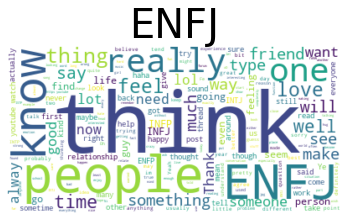

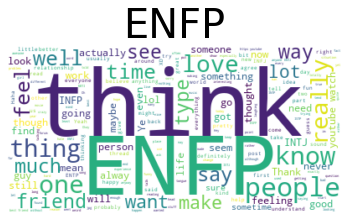

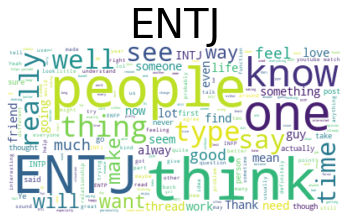

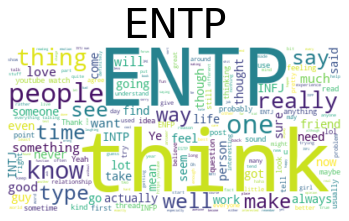

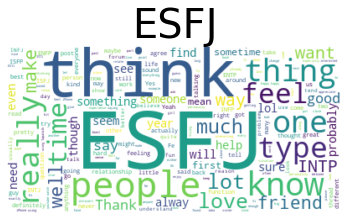

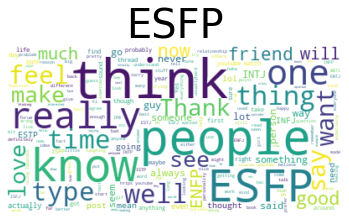

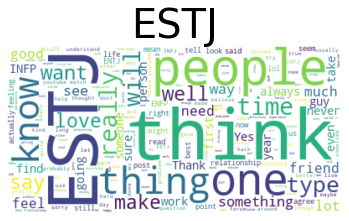

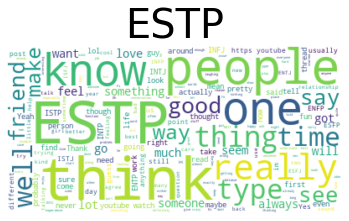

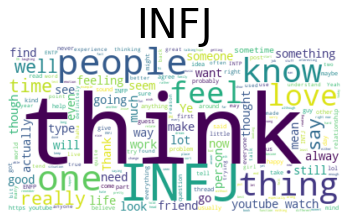

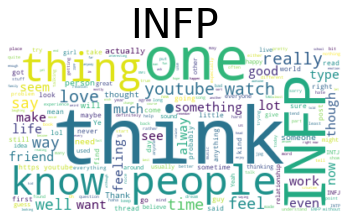

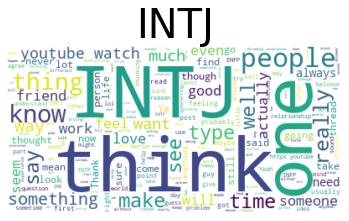

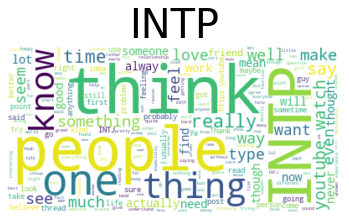

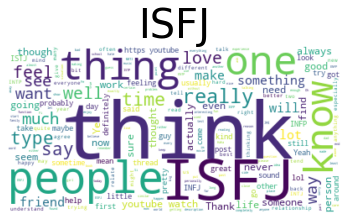

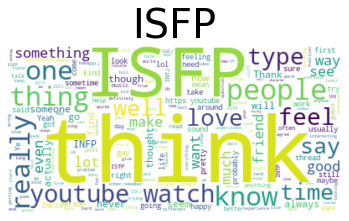

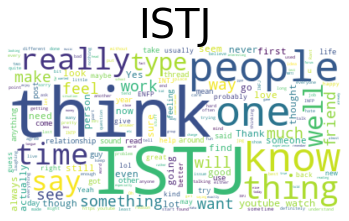

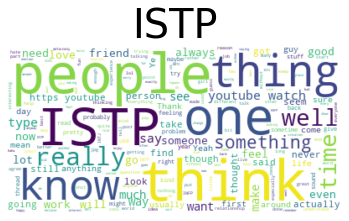

In [72]:
for i, t in enumerate(df_by_personality['type']):
    text = df_by_personality.iloc[i,1]
    generate_wordcloud(text, t)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
Feature ranking:
feature 27466 : feel (0.001476)
feature 48861 : love (0.001240)
feature 68463 : realli (0.000853)
feature 38874 : im (0.000832)
feature 41214 : ive (0.000825)
feature 47547 : life (0.000812)
feature 82055 : thing (0.000804)
feature 85847 : type (0.000775)
feature 93340 : would (0.000762)
feature 47663 : like (0.000753)
feature 90992 : want (0.000746)
feature 81457 : thank (0.000736)
feature 93279 : world (0.000729)
feature 7278 : beauti (0.000728)
feature 35538 : help (0.000727)
feature 29765 : friend (0.000726)
feature 56282 : never (0.000717)
feature 64152 : point (0.000716)
feature 59462 : one (0.000711)
feature 64560 : post (0.000711)


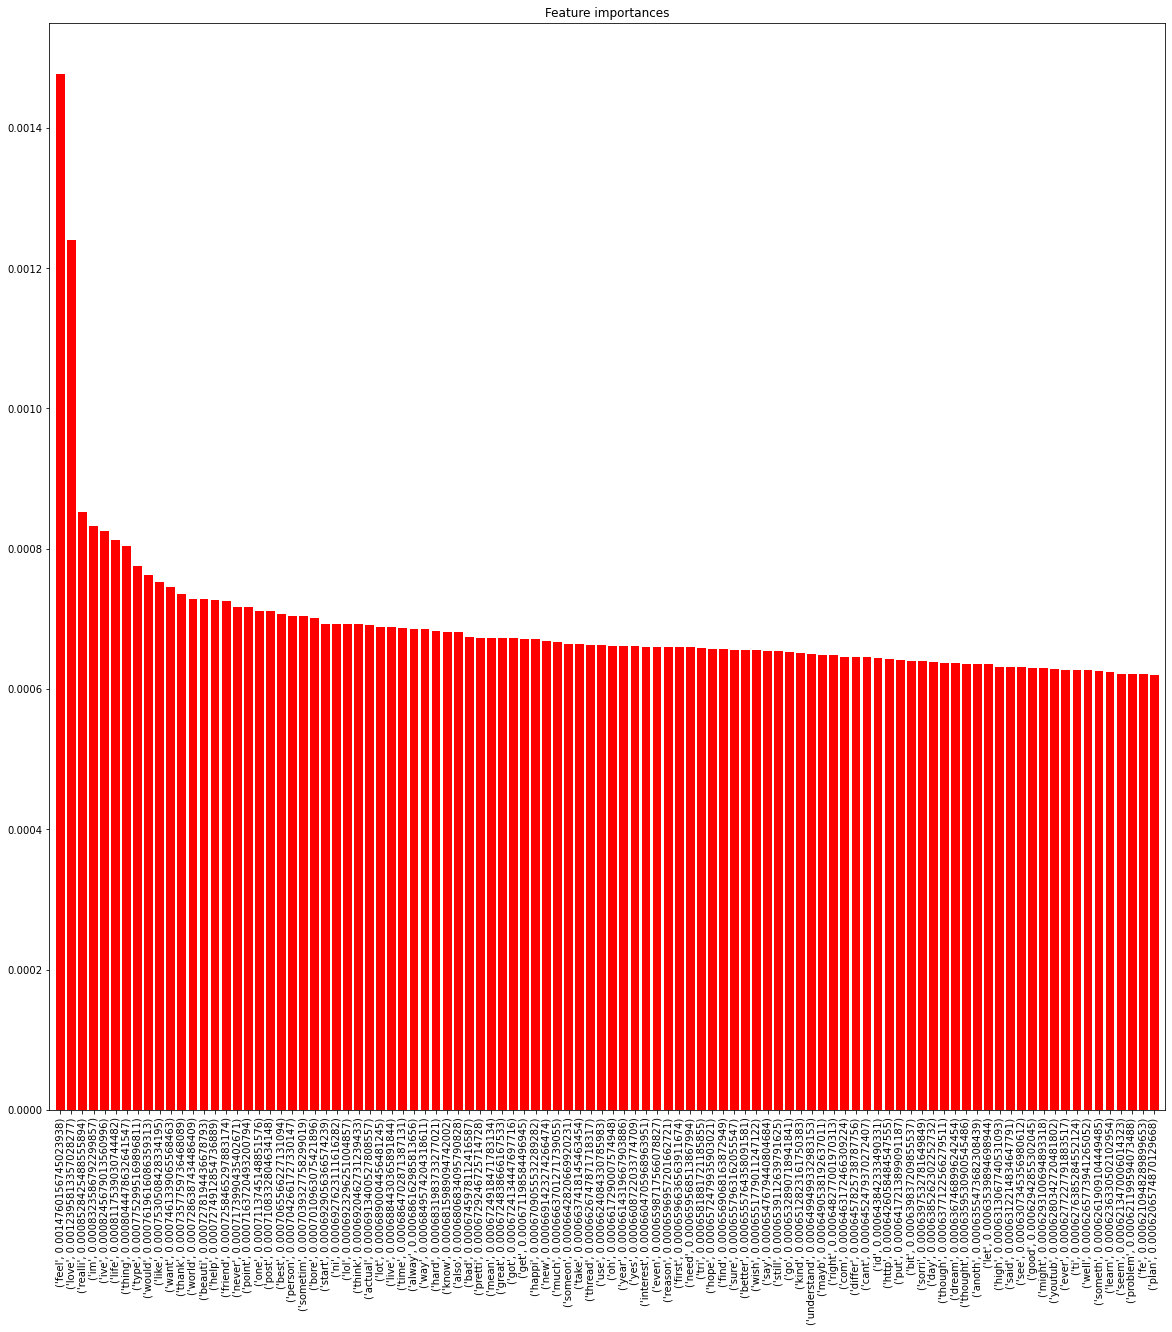

()

In [87]:
import operator
df_mbti['posts'] = rem_sw(df_mbti['posts'])
df_mbti['posts'] = rem_punc(df_mbti['posts'])
df_mbti['posts'] = lemma(df_mbti['posts'])
df_mbti['posts'] = stemma(df_mbti['posts'])
df_mbti['posts'] = rem_sw(df_mbti['posts'])

df_mbti.to_csv("mbti_clean_train.csv")

print_feature(df_mbti)

# Building word2Vec Model

In [14]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

# Set values for various parameters
num_features = 1000   # Word vector dimensionality
min_word_count = 10   # Minimum word count
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print("Training model...")
w2v_model = Word2Vec(sentences, workers=num_workers,
                     size=num_features, min_count=min_word_count,
                     window=context, sample=downsampling)

# calling init_sims will make the model much more memory-efficient.
w2v_model.init_sims(replace=True)

2021-01-13 16:50:08,234 : INFO : collecting all words and their counts
2021-01-13 16:50:08,234 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-01-13 16:50:08,271 : INFO : PROGRESS: at sentence #10000, processed 195305 words, keeping 14289 word types
2021-01-13 16:50:08,300 : INFO : PROGRESS: at sentence #20000, processed 387670 words, keeping 20194 word types
2021-01-13 16:50:08,330 : INFO : PROGRESS: at sentence #30000, processed 575162 words, keeping 24832 word types
2021-01-13 16:50:08,362 : INFO : PROGRESS: at sentence #40000, processed 775325 words, keeping 28949 word types
2021-01-13 16:50:08,393 : INFO : PROGRESS: at sentence #50000, processed 963501 words, keeping 32388 word types
2021-01-13 16:50:08,425 : INFO : PROGRESS: at sentence #60000, processed 1155272 words, keeping 35727 word types
2021-01-13 16:50:08,455 : INFO : PROGRESS: at sentence #70000, processed 1349108 words, keeping 38775 word types


Training model...


2021-01-13 16:50:08,485 : INFO : PROGRESS: at sentence #80000, processed 1533752 words, keeping 41481 word types
2021-01-13 16:50:08,517 : INFO : PROGRESS: at sentence #90000, processed 1731036 words, keeping 44313 word types
2021-01-13 16:50:08,550 : INFO : PROGRESS: at sentence #100000, processed 1925178 words, keeping 47081 word types
2021-01-13 16:50:08,583 : INFO : PROGRESS: at sentence #110000, processed 2125429 words, keeping 49670 word types
2021-01-13 16:50:08,616 : INFO : PROGRESS: at sentence #120000, processed 2312832 words, keeping 52145 word types
2021-01-13 16:50:08,646 : INFO : PROGRESS: at sentence #130000, processed 2511087 words, keeping 54451 word types
2021-01-13 16:50:08,677 : INFO : PROGRESS: at sentence #140000, processed 2708349 words, keeping 56992 word types
2021-01-13 16:50:08,705 : INFO : PROGRESS: at sentence #150000, processed 2904293 words, keeping 59095 word types
2021-01-13 16:50:08,737 : INFO : PROGRESS: at sentence #160000, processed 3108828 words, k

2021-01-13 16:50:24,739 : INFO : EPOCH 1 - PROGRESS: at 74.28% examples, 559975 words/s, in_qsize 7, out_qsize 0
2021-01-13 16:50:25,744 : INFO : EPOCH 1 - PROGRESS: at 81.35% examples, 561594 words/s, in_qsize 7, out_qsize 0
2021-01-13 16:50:26,758 : INFO : EPOCH 1 - PROGRESS: at 88.51% examples, 564142 words/s, in_qsize 8, out_qsize 0
2021-01-13 16:50:27,766 : INFO : EPOCH 1 - PROGRESS: at 95.73% examples, 566636 words/s, in_qsize 7, out_qsize 0
2021-01-13 16:50:28,308 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-01-13 16:50:28,338 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-01-13 16:50:28,346 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-01-13 16:50:28,352 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-01-13 16:50:28,352 : INFO : EPOCH - 1 : training on 11615866 raw words (8356843 effective words) took 14.7s, 568347 effective words/s
2021-01-13 16:50:29,391 : INFO : EPOCH 2 - PR

2021-01-13 16:51:22,486 : INFO : EPOCH 5 - PROGRESS: at 12.35% examples, 506555 words/s, in_qsize 7, out_qsize 0
2021-01-13 16:51:23,522 : INFO : EPOCH 5 - PROGRESS: at 18.86% examples, 513496 words/s, in_qsize 7, out_qsize 0
2021-01-13 16:51:24,561 : INFO : EPOCH 5 - PROGRESS: at 25.31% examples, 516568 words/s, in_qsize 7, out_qsize 0
2021-01-13 16:51:25,562 : INFO : EPOCH 5 - PROGRESS: at 31.58% examples, 518093 words/s, in_qsize 7, out_qsize 0
2021-01-13 16:51:26,566 : INFO : EPOCH 5 - PROGRESS: at 37.79% examples, 518900 words/s, in_qsize 7, out_qsize 0
2021-01-13 16:51:27,598 : INFO : EPOCH 5 - PROGRESS: at 44.10% examples, 518103 words/s, in_qsize 8, out_qsize 0
2021-01-13 16:51:28,602 : INFO : EPOCH 5 - PROGRESS: at 50.68% examples, 520502 words/s, in_qsize 7, out_qsize 0
2021-01-13 16:51:29,614 : INFO : EPOCH 5 - PROGRESS: at 56.18% examples, 512361 words/s, in_qsize 8, out_qsize 0
2021-01-13 16:51:30,618 : INFO : EPOCH 5 - PROGRESS: at 62.25% examples, 512783 words/s, in_qsiz

In [15]:
w2v_model.most_similar('india')


<ipython-input-15-56ca2c62005e>:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  w2v_model.most_similar('india')


[('usa', 0.8085771799087524),
 ('africa', 0.807060956954956),
 ('brazil', 0.7916246652603149),
 ('georgia', 0.7885710000991821),
 ('sweden', 0.7876895666122437),
 ('italy', 0.7818452715873718),
 ('australia', 0.7768093347549438),
 ('spain', 0.77665114402771),
 ('west', 0.7758343815803528),
 ('russia', 0.7736088037490845)]

## FEATURE VECTORIZING

In [16]:
model = w2v_model

In [107]:
def makeFeatureVec(words, model, num_features):

    featureVec = np.zeros((num_features,), dtype="float32")
    #
    nwords = 0.

    index2word_set = set(model.wv.vocab.keys())

    for word in words:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec, model[word])
    #
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec, nwords)
    return featureVec


def getAvgFeatureVecs(posts, model, num_features):

    counter = 0.
    #
    # Preallocate a 2D numpy array, for speed
    postFeatureVecs = np.zeros((len(posts), num_features), dtype="float32")
    #
    # Loop through the posts
    for post in posts:
        #
        # Print a status message every 1000th post
        if counter % 50000. == 0.:
            print("Post %d of %d" % (counter, len(posts)))
        #
        # Call the function (defined above) that makes average feature vectors
        postFeatureVecs[int(counter)] = makeFeatureVec(post, model,
                                                       num_features)
        #
        # Increment the counter
        counter = counter + 1.
    return postFeatureVecs


In [18]:
print("Creating average feature vecs for train posts")
# Initialize an empty list
clean_train_posts = []

# Use our multithreaded 
clean_train_posts = pool.map(post_to_wordlist, train['posts'])

trainDataVecs = getAvgFeatureVecs( clean_train_posts, model, num_features )

print("Creating average feature vecs for test posts")
clean_test_posts = []
clean_test_posts = pool.map(post_to_wordlist, test['posts'])

testDataVecs = getAvgFeatureVecs( clean_test_posts, model, num_features )

Creating average feature vecs for train posts
Post 0 of 6925


<ipython-input-17-b3b88688e51b>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  featureVec = np.add(featureVec, model[word])


Creating average feature vecs for test posts
Post 0 of 1750


In [19]:
len(testDataVecs)

1750

In [20]:
y = train[['mind', 'energy', 'nature', 'tactics']]
y_mind = train['mind']
y_energy = train['energy']
y_nature = train['nature']
y_tactics = train['tactics']
X = trainDataVecs
X_test = testDataVecs

In [21]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.2, random_state=42)

# MODELS TRAINING


In [94]:
lr = LogisticRegression(solver='saga', class_weight='balanced', penalty='elasticnet')
abc = AdaBoostClassifier()
gbc = GradientBoostingClassifier()
xgb = XGBClassifier(n_estimators=100)
knn = KNeighborsClassifier()
nb = GaussianNB()
dtree = DecisionTreeClassifier()
rf = RandomForestClassifier()
svc = SVC()
scaler_gnb = MaxAbsScaler()
nusv = NuSVC()
lsvc = LinearSVC()


In [95]:
params_lr = {'l1_ratio': [0.7, 0.9]}
params_abc = {}
params_gbc =  {'n_estimators': [16, 32], 'learning_rate': [0.8, 1.0]}
params_xgb = {}
params_knn = {}
params_nb = {}
params_dtree = {} 
params_rf = {}
params_svc = {}
params_scalar_gnb = {}
params_nusv = {}
params_lsvc = {}

In [96]:
def train_tune(model, params, X, y, X_validate=X_validate):
    
    gs_mind = GridSearchCV(model, params, n_jobs=4, cv = 10, verbose=3)
    gs_energy = GridSearchCV(model, params, n_jobs=4,cv = 10, verbose=3)
    gs_nature = GridSearchCV(model, params, n_jobs=4,cv = 10, verbose=3)
    gs_tactics = GridSearchCV(model, params, n_jobs=4,cv = 10, verbose=3)
    
    mind = gs_mind.fit(X, y['mind'])
    energy = gs_energy.fit(X, y['energy'])
    nature = gs_nature.fit(X, y['nature'])
    tactics = gs_tactics.fit(X, y['tactics'])
    
    print('Best parameters for I/E : {}'.format(gs_mind.best_params_))
    print('Best parameters for N/S: {}'.format(gs_energy.best_params_))
    print('Best parameters for T/F: {}'.format(gs_nature.best_params_))
    print('Best parameters for J/P: {}'.format(gs_tactics.best_params_))
    
    return (mind, energy, nature, tactics)

In [97]:
def score_model(mind, energy, nature, tactics):
    
    score_m = accuracy_score(y_validate['mind'], mind.predict(X_validate))
    score_e = accuracy_score(y_validate['energy'], energy.predict(X_validate))
    score_n = accuracy_score(y_validate['nature'], nature.predict(X_validate))
    score_t = accuracy_score(y_validate['tactics'], tactics.predict(X_validate))

    overall = (score_m + score_e + score_n + score_t)/4
    print('Overall Score: {}'.format((score_m+score_e+score_n+score_t)/4))
    print('I/E accuracy: {}'.format(score_m))
    print('N/S accuracy: {}'.format(score_e))
    print('T/F accuracy: {}'.format(score_n))
    print('J/P accuracy: {}'.format(score_t))
    
    return [overall,score_m, score_e, score_n, score_t]
    

## Naive Bayes Classifier

In [108]:
mind_nb, energy_nb, nature_nb, tactics_nb = train_tune(nb, params_nb, X = X_train, y=y_train)

print('Naive Bayes Classifier Scoring:')
nb_scores = score_model(mind_nb, energy_nb, nature_nb, tactics_nb)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.9s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.9s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    0.2s finished


Best parameters for I/E : {}
Best parameters for N/S: {}
Best parameters for T/F: {}
Best parameters for J/P: {}
Naive Bayes Classifier Scoring:
Overall Score: 0.628158844765343
I/E accuracy: 0.488086642599278
N/S accuracy: 0.7494584837545126
T/F accuracy: 0.68014440433213
J/P accuracy: 0.5949458483754513


## Logistic Regression

In [111]:
mind_lr, energy_lr, nature_lr, tactics_lr = train_tune(lr, params_lr, X = X_train, y=y_train)

print('Logistic Regression Scoring:')
lr_scores = score_model(mind_lr, energy_lr, nature_lr, tactics_lr)

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.8s finished


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   13.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   13.3s finished


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   13.9s finished


Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.1s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   12.1s finished


Best parameters for I/E : {'l1_ratio': 0.7}
Best parameters for N/S: {'l1_ratio': 0.7}
Best parameters for T/F: {'l1_ratio': 0.9}
Best parameters for J/P: {'l1_ratio': 0.7}
Logistic Regression Scoring:
Overall Score: 0.6111913357400722
I/E accuracy: 0.5884476534296029
N/S accuracy: 0.6108303249097473
T/F accuracy: 0.68014440433213
J/P accuracy: 0.5653429602888087


## Adaboost Classifier

In [112]:
mind_abc, energy_abc, nature_abc, tactics_abc = train_tune(abc, params_abc, X = X_train, y=y_train)

print('AdaBoost Classifier Scoring:')
abc_scores = score_model(mind_abc, energy_abc, nature_abc, tactics_abc)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   50.6s remaining:   21.7s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.2min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   49.2s remaining:   21.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.2min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   49.2s remaining:   21.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.2min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   49.2s remaining:   21.1s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.2min finished


Best parameters for I/E : {}
Best parameters for N/S: {}
Best parameters for T/F: {}
Best parameters for J/P: {}
AdaBoost Classifier Scoring:
Overall Score: 0.7505415162454874
I/E accuracy: 0.7747292418772563
N/S accuracy: 0.8505415162454874
T/F accuracy: 0.7545126353790613
J/P accuracy: 0.6223826714801444


## Gradient Boosting Classifier

In [120]:
mind_gbc, energy_gbc, nature_gbc, tactics_gbc = train_tune(gbc, params_gbc, X = X_train, y=y_train)

print('Gradient Boosting Classifier Scoring:')
gbc_scores = score_model(mind_gbc, energy_gbc, nature_gbc, tactics_gbc)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  5.8min finished


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  5.6min finished


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed: 41.1min finished


Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  3.2min
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:  5.5min finished


Best parameters for I/E : {'learning_rate': 0.8, 'n_estimators': 16}
Best parameters for N/S: {'learning_rate': 0.8, 'n_estimators': 16}
Best parameters for T/F: {'learning_rate': 0.8, 'n_estimators': 32}
Best parameters for J/P: {'learning_rate': 0.8, 'n_estimators': 16}
Gradient Boosting Classifier Scoring:
Overall Score: 0.738086642599278
I/E accuracy: 0.755956678700361
N/S accuracy: 0.8353790613718411
T/F accuracy: 0.7501805054151625
J/P accuracy: 0.6108303249097473


## Decision Tree Classifier

In [114]:
mind_dtree, energy_dtree, nature_dtree, tactics_dtree = train_tune(dtree, params_dtree, X = X_train, y=y_train)

print('Decision Tree Classifier Scoring:')
dtree_scores = score_model(mind_dtree, energy_dtree, nature_dtree, tactics_dtree)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   15.5s remaining:    6.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   21.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   25.4s remaining:   10.9s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   34.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   13.0s remaining:    5.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   17.6s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   12.4s remaining:    5.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   16.9s finished


Best parameters for I/E : {}
Best parameters for N/S: {}
Best parameters for T/F: {}
Best parameters for J/P: {}
Decision Tree Classifier Scoring:
Overall Score: 0.655956678700361
I/E accuracy: 0.6866425992779783
N/S accuracy: 0.7610108303249098
T/F accuracy: 0.6259927797833935
J/P accuracy: 0.5501805054151625


## Random Forest Classifier

In [115]:
mind_rf, energy_rf, nature_rf, tactics_rf = train_tune(rf, params_rf, X = X_train, y=y_train)

print('Random Forest Classifier Scoring:')
rf_scores = score_model(mind_rf, energy_rf, nature_rf, tactics_rf)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   24.5s remaining:   10.5s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   34.2s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   33.5s remaining:   14.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   46.5s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   21.5s remaining:    9.2s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   30.1s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   22.9s remaining:    9.8s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   32.2s finished


Best parameters for I/E : {}
Best parameters for N/S: {}
Best parameters for T/F: {}
Best parameters for J/P: {}
Random Forest Classifier Scoring:
Overall Score: 0.7483754512635379
I/E accuracy: 0.7732851985559567
N/S accuracy: 0.8534296028880867
T/F accuracy: 0.752346570397112
J/P accuracy: 0.6144404332129964


## Support Vector Classifier

In [116]:
mind_svc, energy_svc, nature_svc, tactics_svc = train_tune(svc, params_svc, X = X_train, y=y_train)

print('Support Vector Classifier Scoring:')
svc_scores = score_model(mind_svc, energy_svc, nature_svc, tactics_svc)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   45.4s remaining:   19.5s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.1min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   33.5s remaining:   14.4s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   46.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:   56.8s remaining:   24.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.3min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  1.2min remaining:   30.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.6min finished


Best parameters for I/E : {}
Best parameters for N/S: {}
Best parameters for T/F: {}
Best parameters for J/P: {}
Support Vector Classifier Scoring:
Overall Score: 0.7592057761732851
I/E accuracy: 0.7725631768953068
N/S accuracy: 0.8563176895306859
T/F accuracy: 0.8014440433212996
J/P accuracy: 0.6064981949458483


## XGboost Classifier

In [117]:
mind_xgb, energy_xgb, nature_xgb, tactics_xgb = train_tune(xgb, params_xgb, X = X_train, y=y_train)

print('XGboost:')
xgb_scores = score_model(mind_xgb, energy_xgb, nature_xgb, tactics_xgb)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  1.6min remaining:   40.9s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  2.0min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  8.1min remaining:  3.5min
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  8.4min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  1.4min remaining:   36.3s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.8min finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:  1.5min remaining:   37.8s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:  1.9min finished


Best parameters for I/E : {}
Best parameters for N/S: {}
Best parameters for T/F: {}
Best parameters for J/P: {}
XGboost:
Overall Score: 0.7554151624548737
I/E accuracy: 0.7740072202166065
N/S accuracy: 0.8592057761732852
T/F accuracy: 0.7783393501805054
J/P accuracy: 0.6101083032490975


## Linear Support vector Classifier

In [118]:
mind_lsvc, energy_lsvc, nature_lsvc, tactics_lsvc = train_tune(lsvc, params_lsvc, X = X_train, y=y_train)

print('Linear Support vector Classifier Scoring:')
lsvc_scores = score_model(mind_lsvc, energy_lsvc, nature_lsvc, tactics_lsvc)


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.6s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.2s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.7s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.8s finished


Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    1.3s remaining:    0.5s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    1.8s finished


Best parameters for I/E : {}
Best parameters for N/S: {}
Best parameters for T/F: {}
Best parameters for J/P: {}
Linear Support vector Classifier Scoring:
Overall Score: 0.751985559566787
I/E accuracy: 0.7747292418772563
N/S accuracy: 0.8563176895306859
T/F accuracy: 0.763898916967509
J/P accuracy: 0.6129963898916968


In [121]:
score_df = pd.DataFrame({
    'LogisticRegression': lr_scores,
    'AdaBoost': abc_scores,
    'GradientBoost': gbc_scores,
    'XGBoost': xgb_scores,
    'NaiveBayes': nb_scores,
    'DecisionTree': dtree_scores,
    'RandomForest': rf_scores,
    'support Vector': svc_scores,
    'LinearSVC': lsvc_scores
}, index = ['Overall','I/E', 'N/S', 'T/F', 'J/P'])

# Models  Comparison Table

In [122]:
score_df

,LogisticRegression,AdaBoost,GradientBoost,XGBoost,NaiveBayes,DecisionTree,RandomForest,support Vector,LinearSVC
Overall,0.611191,0.750542,0.738087,0.755415,0.628159,0.655957,0.748375,0.759206,0.751986
I/E,0.588448,0.774729,0.755957,0.774007,0.488087,0.686643,0.773285,0.772563,0.774729
N/S,0.610830,0.850542,0.835379,0.859206,0.749458,0.761011,0.853430,0.856318,0.856318
T/F,0.680144,0.754513,0.750181,0.778339,0.680144,0.625993,0.752347,0.801444,0.763899
J/P,0.565343,0.622383,0.610830,0.610108,0.594946,0.550181,0.614440,0.606498,0.612996
